In [1]:
# Libraries
import sys
sys.path.insert(0, '../../src')
import harmoutil

import numpy as np

from keras.models import Model
from keras.layers import Input, Dense

import tensorflow as tf

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data
raw_data = harmoutil.load_pickled_data("../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
data = [harmoutil.to_sevenths(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

In [3]:
# Create individual chord and melody element lists 
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False


# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
# data = [section for section in data if not check_if_augmented_major(section)]
# print("---Remove sections with augmented major chord---")
# print("Number of sections: {}\n".format(len(data)))

chords_by_sections = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords for note in chord_notes]
# print(sum([len(section) for section in chords_by_sections]))
print("Number of sections: {} | Sample section chords: {}".format(len(chords_by_sections), chords_by_sections[0]))
print("Number of chords: {} | Sample chord: {}".format(len(chords), chords[0]))
print("Number of melodies {} | Sample melody: {}".format(len(notes_by_chords), notes_by_chords[0]))
print("Number of melody notes in the data: {} | Sample melody note: {}".format(len(notes), notes[0]))

Number of sections: 28884 | Sample section chords: ['E6', 'Db7', 'Gb-7', 'B7', 'E', 'Db-7', 'Gb-7', 'B7', 'B-7', 'E7', 'A7', 'D7', 'Ab-7', 'Db7', 'Gb-7', 'B7']
Number of chords: 334344 | Sample chord: E6
Number of melodies 334344 | Sample melody: [4, 4]
Number of melody notes in the data: 2209944 | Sample melody note: 4


In [4]:
# Keep only relevant data (chords with melody and non-NC chords)
relevant_chords = []
relevant_melody = []
for i, (ch, mel) in enumerate(zip(chords, notes_by_chords)):
    if (ch != 'NC') and (not list(set(mel)) == [-1]):
        relevant_chords.append(ch)
        relevant_melody.append([n for n in mel if n != -1])

unique_notes = list(sorted(list(set([note for ch_mel in relevant_melody for note in ch_mel]))))
unique_chords = list(sorted(list(set(relevant_chords))))

print(len(unique_notes), len(unique_chords))

12 192


In [5]:
# Prepare root data
relevant_roots = [harmoutil.split_root_suffix(ch)[0] for ch in relevant_chords]
unique_roots = list(sorted(list(set(relevant_roots))))

# Prepare the interval data
relevant_suffixes = [harmoutil.split_root_suffix(ch)[1] for ch in relevant_chords]
unique_suffixes = list(sorted(list(set(relevant_suffixes))))
relevant_intervals = [harmoutil.root_position(sf) for sf in relevant_suffixes]

# Prepare the pitch data
relevant_pitches = [harmoutil.chord_to_notes(ch) for ch in relevant_chords]

# Prepare the melody BoW data
def seq_to_bow(melseq):
    bow = [0]*12
    for note in melseq:
        bow[note] += 1
    return bow

relevant_melody_bow = [seq_to_bow(seq) for seq in relevant_melody]

In [6]:
# Create categorical data mappings

# Note to integer index
note_to_int = dict([(c, i) for i, c in enumerate(unique_notes)])
print("Melody note to integer mapping:\n {}\n".format(note_to_int))

# Integer to note
int_to_note = dict([(k, v) for v, k in note_to_int.items()])
print("Integer to melody note mapping:\n {}\n".format(int_to_note))

# Note to integer index
root_to_int = dict([(c, i) for i, c in enumerate(unique_roots)])
print("Melody note to integer mapping:\n {}\n".format(root_to_int))

# Integer to note
int_to_root = dict([(k, v) for v, k in root_to_int.items()])
print("Integer to melody note mapping:\n {}\n".format(int_to_root))

# Chord to integer index
chord_to_int = dict([(c, i) for i, c in enumerate(unique_chords)])
# chord_to_int['<bos>'] = len(chord_to_int)
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))

# Integer to chord index
int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))

Melody note to integer mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11}

Integer to melody note mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11}

Melody note to integer mapping:
 {'A': 0, 'Ab': 1, 'B': 2, 'Bb': 3, 'C': 4, 'D': 5, 'Db': 6, 'E': 7, 'Eb': 8, 'F': 9, 'G': 10, 'Gb': 11}

Integer to melody note mapping:
 {0: 'A', 1: 'Ab', 2: 'B', 3: 'Bb', 4: 'C', 5: 'D', 6: 'Db', 7: 'E', 8: 'Eb', 9: 'F', 10: 'G', 11: 'Gb'}

Chord label to integer mapping:
 {'A': 0, 'A+': 1, 'A+7': 2, 'A+j7': 3, 'A-': 4, 'A-6': 5, 'A-7': 6, 'A-j7': 7, 'A6': 8, 'A7': 9, 'Ab': 10, 'Ab+': 11, 'Ab+7': 12, 'Ab+j7': 13, 'Ab-': 14, 'Ab-6': 15, 'Ab-7': 16, 'Ab-j7': 17, 'Ab6': 18, 'Ab7': 19, 'Abj7': 20, 'Abm7b5': 21, 'Abo': 22, 'Abo7': 23, 'Absus': 24, 'Absus7': 25, 'Aj7': 26, 'Am7b5': 27, 'Ao': 28, 'Ao7': 29, 'Asus': 30, 'Asus7': 31, 'B': 32, 'B+': 33, 'B+7': 34, 'B+j7': 35, 'B-': 36, 'B-6': 37, 'B-7': 38, 'B-j7': 39, 'B6': 40, 'B7': 41, 'Bb'

In [7]:
for i in range(3):
    print("---")
    print("Chord {}\nRoot {}\nMelody {}\nIntervals {}\nPitches {}".format(relevant_chords[i], relevant_roots[i], relevant_melody_bow[i], relevant_intervals[i], relevant_pitches[i]))

---
Chord E6
Root E
Melody [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]
Intervals [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
Pitches [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]
---
Chord Db-7
Root Db
Melody [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Intervals [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
Pitches [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]
---
Chord Gb-7
Root Gb
Melody [0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]
Intervals [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
Pitches [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]


In [8]:
# Define numerical variables

n_samples = len(relevant_chords)
n_notes = len(note_to_int)
n_roots = len(root_to_int)
n_chords = len(chord_to_int)
n_pitches = 12
n_intervals = 12
n_dimensions = 32


print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_notes))
print("Number of distinct root notes: {}".format(n_roots))
print("Number of interval positions: {}".format(n_intervals))
print("Number of distinct pitches: {}".format(n_pitches))
print("Number of distinct chord labels: {}".format(n_chords))
print("Number of dimensions in embedding vectors: {}".format(n_dimensions))

Total number of samples: 311064
Number of distinct melody notes: 12
Number of distinct root notes: 12
Number of interval positions: 12
Number of distinct pitches: 12
Number of distinct chord labels: 192
Number of dimensions in embedding vectors: 32


In [9]:
# Prepare tensors
X = np.zeros((n_samples, n_chords), dtype='float32')
Y_melody = np.zeros((n_samples, n_notes), dtype='float32')
Y_intervals = np.zeros((n_samples, n_intervals), dtype='float32')
Y_pitches = np.zeros((n_samples, n_pitches), dtype='float32')
Y_roots = np.zeros((n_samples, n_roots), dtype='float32')

for i, (chord, rt, pos, pit, melody_bow) in enumerate(zip(relevant_chords, relevant_roots, relevant_intervals, relevant_pitches, relevant_melody_bow)):
    X[i, chord_to_int[chord]] = 1

    Y_roots[i, root_to_int[rt]] = 1
    for j, pos_presence in enumerate(pos):
        Y_intervals[i, j] = pos_presence
    for j, pit_presence in enumerate(pit):
        Y_pitches[i, j] = pit_presence
    for j, cnt in enumerate(melody_bow):
        Y_melody[i, j] = cnt

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192)          0                                            
__________________________________________________________________________________________________
embeddings (Dense)              (None, 32)           6176        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12)           396         embeddings[0][0]                 
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12)           396         embeddings[0][0]                 
__________________________________________________________________________________________________
dense_3 (D

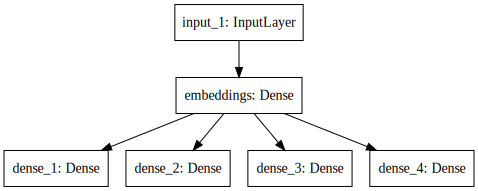

In [10]:
# Build model (Keras)

input_layer = Input(shape=(n_chords,)) # (n_samples * n_chords)
embeddings_layer = Dense(n_dimensions, activation='linear', name="embeddings")(input_layer) # in:(n_samples * n_chords) . hid:(n_chords * n_dimensions) = out:(n_samples * n_dimensions)


root_output_layer = Dense(n_roots, activation='softmax')(embeddings_layer) # in:(n_samples * n_dimensions) . hid:(n_dimensions * n_notes) = out:(n_samples * n_notes)
interval_output_layer = Dense(n_intervals, activation='sigmoid')(embeddings_layer)
pitch_output_layer = Dense(n_pitches, activation='sigmoid')(embeddings_layer)
melody_output_layer = Dense(n_notes, activation='relu')(embeddings_layer)

model = Model(input_layer, [root_output_layer, interval_output_layer, pitch_output_layer, melody_output_layer])
model.compile(loss=['categorical_crossentropy', 'binary_crossentropy', 'binary_crossentropy', 'mse'],
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [11]:
# Train model
batch_size = 32
epochs = 5

history = model.fit(X, [Y_roots, Y_intervals, Y_pitches, Y_melody], epochs=epochs, batch_size=batch_size)

Epoch 1/5
311064/311064 [==============================] - 35s 114us/step - loss: 0.9735 - dense_1_loss: 0.0813 - dense_2_loss: 0.0558 - dense_3_loss: 0.0628 - dense_4_loss: 0.7736 - dense_1_acc: 0.9926 - dense_2_acc: 0.9821 - dense_3_acc: 0.9789 - dense_4_acc: 0.1653
Epoch 2/5
311064/311064 [==============================] - 37s 118us/step - loss: 0.7655 - dense_1_loss: 1.0413e-04 - dense_2_loss: 5.1825e-04 - dense_3_loss: 3.8881e-04 - dense_4_loss: 0.7645 - dense_1_acc: 1.0000 - dense_2_acc: 0.9999 - dense_3_acc: 1.0000 - dense_4_acc: 0.1690
Epoch 3/5
311064/311064 [==============================] - 34s 110us/step - loss: 0.7640 - dense_1_loss: 1.6110e-05 - dense_2_loss: 1.3382e-04 - dense_3_loss: 1.0009e-04 - dense_4_loss: 0.7638 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000 - dense_3_acc: 1.0000 - dense_4_acc: 0.1684
Epoch 4/5
311064/311064 [==============================] - 36s 115us/step - loss: 0.7636 - dense_1_loss: 5.9171e-06 - dense_2_loss: 3.5562e-05 - dense_3_loss: 3.1984e-05

In [12]:
# Retrieve embedding weights
embeddings_X = model.layers[1].get_weights()[0]
print(embeddings_X.shape)

(192, 32)


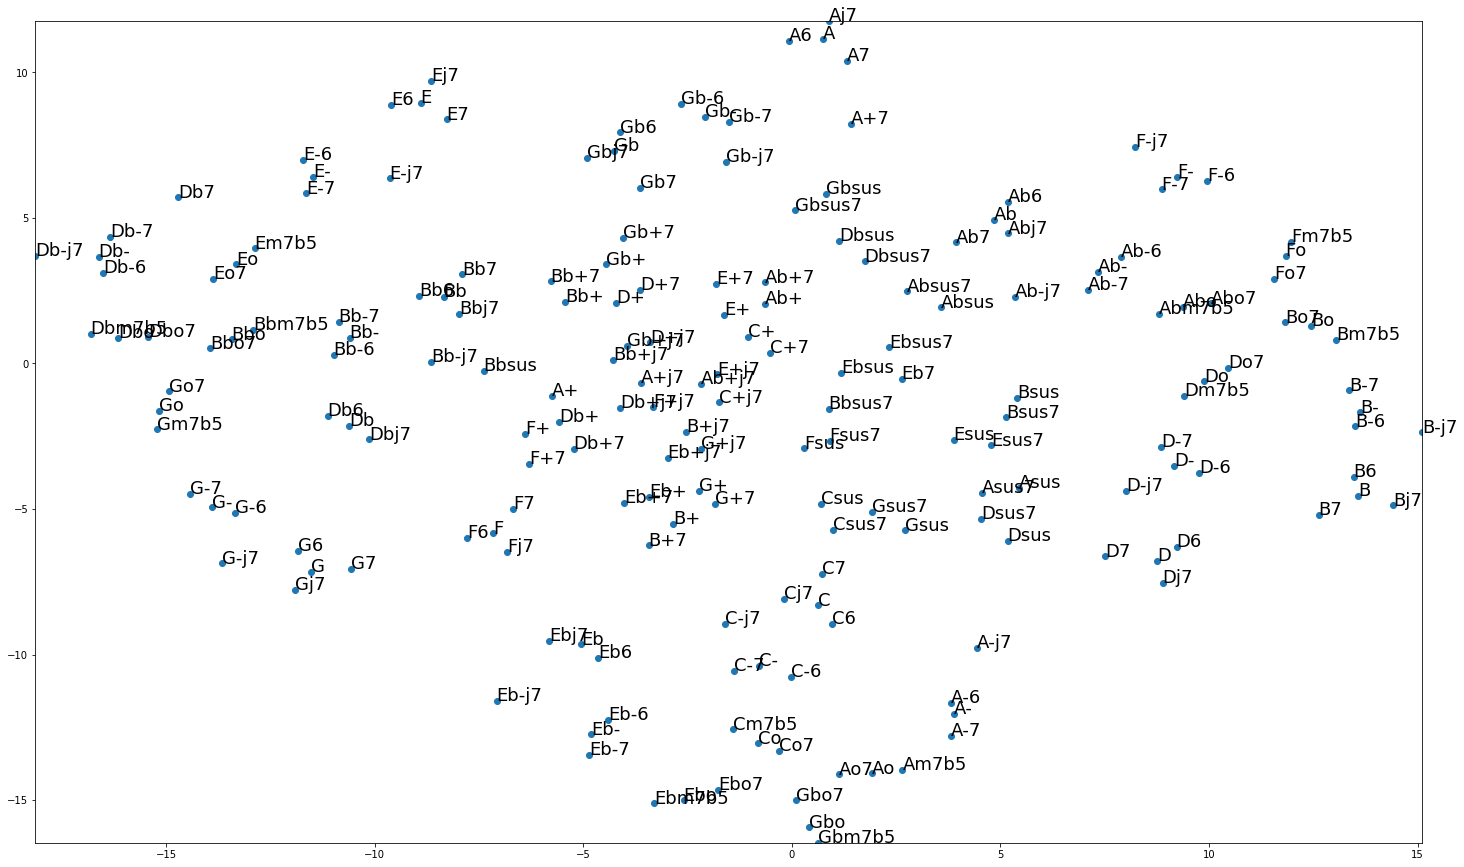

In [13]:
# Train t-SNE
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
embeddings_Y = tsne.fit_transform(embeddings_X)

x_coords = embeddings_Y[:, 0]
y_coords = embeddings_Y[:, 1]
# display scatter plot
plt.figure(figsize=(20,12))
plt.scatter(x_coords, y_coords)

for label, x, y in zip(unique_chords, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=18)
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.tight_layout()#rect=[-0.1, 0, 1, 1])
plt.savefig('combined_tsne.eps', format='eps')
plt.show()

In [14]:
# Reorder embeddings and labels
def reorder_labels_and_embeddings(labels, embeddings):
    notes = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']
    re_labels = []
    re_embeddings = []
    for note in notes:
        for lab, emb in zip(labels, embeddings):                
            rt, sf = harmoutil.split_root_suffix(lab) 
            if (note == rt):
                re_labels.append(lab)
                re_embeddings.append(emb)                
    return re_labels, re_embeddings
        
reordered_labels, reordered_embeddings = reorder_labels_and_embeddings(unique_chords, embeddings_X)

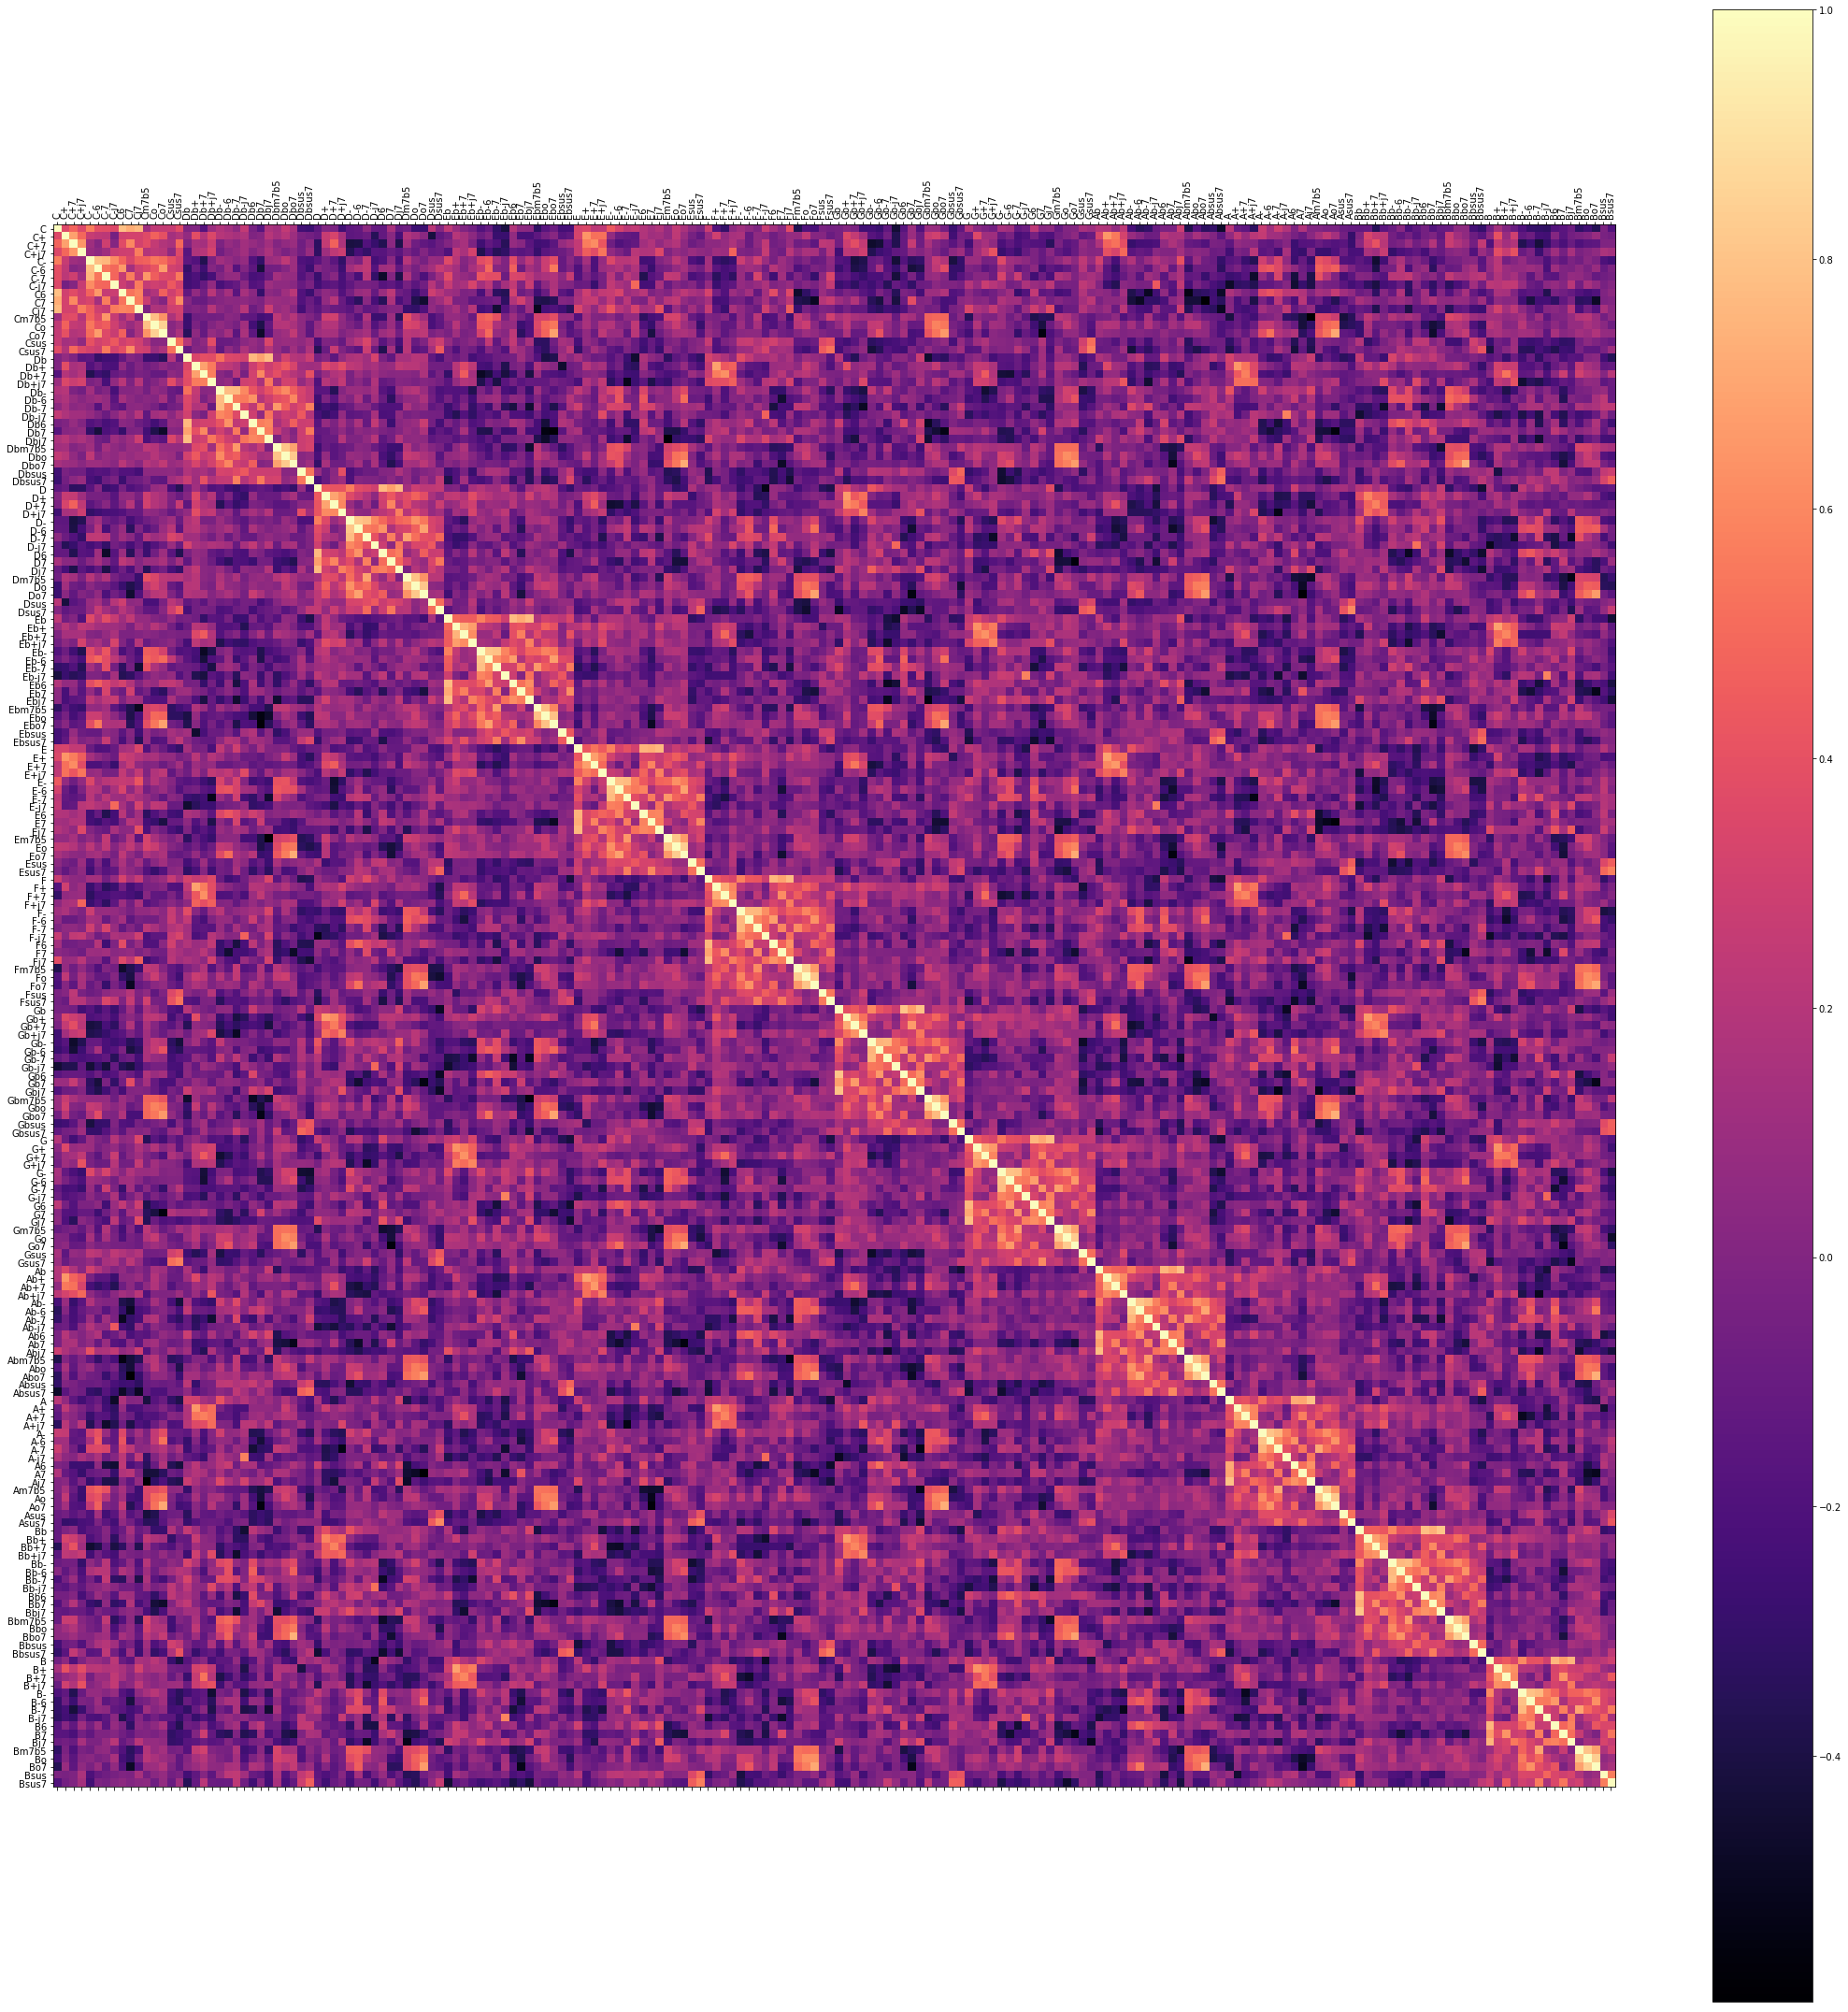

In [15]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

# Compute distance matrix

distance_matrix = np.zeros((len(reordered_labels), len(reordered_labels)), dtype='float32')
for i, vec1 in enumerate(reordered_embeddings):
    for j, vec2 in enumerate(reordered_embeddings):
#         distance_matrix[i, j] = -np.linalg.norm(vec2-vec1)
        distance_matrix[i, j] = cosine_similarity(vec1, vec2)



plt.figure(figsize=(30,30))              
ax = plt.axes()                 
im = ax.matshow(distance_matrix, cmap='magma')      
plt.colorbar(im, ax=ax)               
plt.xticks(np.arange(len(unique_chords)), reordered_labels, rotation='vertical')
plt.yticks(np.arange(len(unique_chords)), reordered_labels)

plt.tight_layout()#rect=[-0.1, 0, 1, 1])
plt.savefig('combined_cosine.eps', format='eps')
plt.show()

In [16]:
# Save the embeddings
model.save_weights("weights/combined_weights_dim32.h5")